In [1]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
import pickle
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.formatter.use_locale'] = True

In [2]:
# reading data
c2g_data = pd.read_csv('data/demand_datasets/c2g_demand.csv', index_col=0)

In [3]:
# cleaning process
c2g_data.index = pd.to_datetime(c2g_data.index)

In [4]:
init_period = '2016-12-13 15:00'
end_period = '2017-02-25 17:00'

c2g_data = c2g_data[(c2g_data.index >= init_period) & (c2g_data.index <= end_period)]

# shift the dataset in 24 hours to split the data equals to the time shift models
c2g_data = c2g_data.iloc[24:]

In [5]:
# splitting in train (80%) and test data (20%)
def split(data, perc=0.8):
    index = int(len(data)*perc)
    return data[:index], data[index:]

c2g_train, c2g_test = split(c2g_data.copy())

In [6]:
# use only the travels
c2g_travels_train, c2g_travels_test = c2g_train.travels, c2g_test.travels

In [11]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)  # MSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'mse':mse, 
            'corr':corr, 'minmax':minmax})

In [9]:
def test_auto_feed(model, train, test, predict_period=12, path=None):
    """
    Test prediction of the next period in hours.
    In this test each predicted value is included in the training set before the new prediction
    As default it will predict the first 12 hours of the test dataset.
    """
    
    to_train = train.copy()
    
    test_values = []
    final_predictions = []
    for i in tqdm(range(len(test)-predict_period)):
        to_test = test[i:predict_period+i].copy()
        predictions = []
        test_values.append(to_test.values)

        to_train_feed = to_train.copy()
        for _ in range(len(to_test)):
            model.fit(to_train_feed.values)

            prediction = model.predict(n_periods=1)
            predictions.append(prediction[0])

            # removing the first input from the test set
            to_test = to_test.iloc[1:]

            # append the last prediction to the train set
            to_train_feed = to_train_feed.append(pd.Series(prediction))

        to_train = to_train.append(to_test)
        final_predictions.append(predictions)
    
    test_values = np.array(test_values)
    final_predictions = np.array(final_predictions)
    results = (test_values, final_predictions)
    
    pickle.dump(results, open( path+"auto_feed_results.p", "wb" ))
    
    return results

In [10]:
def test_future_period(model, train, test, predict_period=168, path=None):
    """
    Test prediction of a future period.
    In this test each already tested period is included in the training set before the new prediction
    As default it will predict the first week of the test dataset.
    """
    
    test_values = []
    final_predictions = []
    for i in tqdm(range(len(test)-predict_period)):
        to_train, to_test = train.copy(), test[i:i+predict_period].copy()
        if i > 0:
            to_train = to_train.append(test[:i].copy())

        test_values.append(to_test.values)

        model.fit(to_train.values)
        predictions = model.predict(n_periods=predict_period)
        final_predictions.append(predictions)
    
    test_values = np.array(test_values)
    final_predictions = np.array(final_predictions)
    results = (test_values, final_predictions)
    
    pickle.dump(results, open( path+"future_period_results.p", "wb" ))
    
    return results

# Auto ARIMA

Looking for the best parameters

In [10]:
model = pm.auto_arima(c2g_travels_train, start_p=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, seasonal=False,
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = False,
                          random_state=20,n_fits = 50)

print(model.summary())

Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=16804.139, BIC=16814.660, Time=3.997 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=15381.269, BIC=15397.051, Time=1.565 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=14607.225, BIC=14628.267, Time=2.910 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=14157.494, BIC=14183.797, Time=3.946 seconds
Fit ARIMA(0,0,4)x(0,0,0,0) [intercept=True]; AIC=13945.899, BIC=13977.462, Time=5.662 seconds
Fit ARIMA(0,0,5)x(0,0,0,0) [intercept=True]; AIC=13892.692, BIC=13929.515, Time=5.106 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=14331.843, BIC=14347.625, Time=0.335 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=14004.059, BIC=14025.101, Time=1.785 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=13869.761, BIC=13896.063, Time=2.222 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=13828.179, BIC=13859.742, Time=3.799 seconds
Fit ARIMA(1,0,4)x(0,0,0,0) [intercept=True]; AIC=13827.896, 

Best model test

In [7]:
model = pm.ARIMA(order=(2, 0, 3))

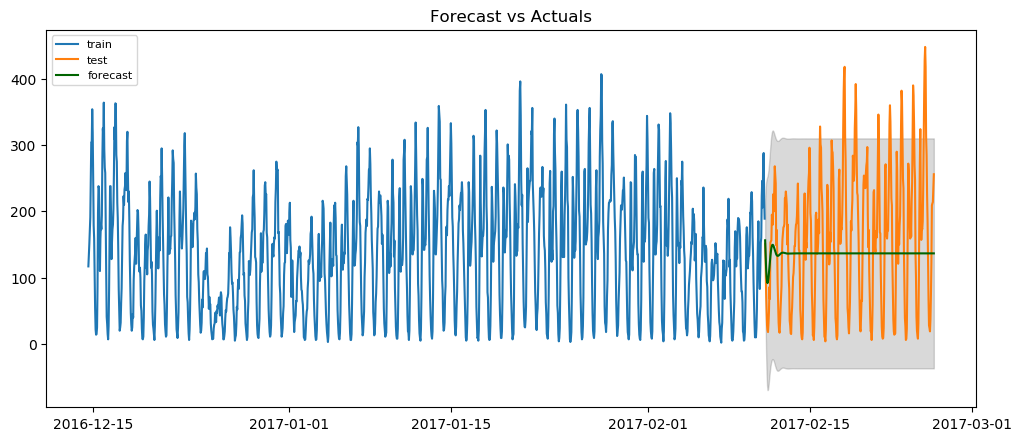

In [9]:
# Forecast
model.fit(c2g_travels_train)
n_periods = len(c2g_travels_test)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

# make series for plotting purpose
fc_series = pd.Series(fc, index=c2g_travels_test.index)
lower_series = pd.Series(confint[:, 0], index=c2g_travels_test.index)
upper_series = pd.Series(confint[:, 1], index=c2g_travels_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(c2g_travels_train, label='train')
plt.plot(c2g_travels_test, label='test')
plt.plot(fc_series, color='darkgreen', label='forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.title('Forecast vs Actuals')
plt.show()

In [12]:
forecast_accuracy(c2g_travels_test.values, fc_series.values)

{'corr': 0.19546873123371722,
 'mae': 85.48861652859615,
 'mape': 0.6287881593353195,
 'me': 25.763400920788083,
 'minmax': 0.4360921689241035,
 'mpe': 0.18403901863004835,
 'mse': 10866.708451775023}

In [12]:
c2g_arima_auto_feed = test_auto_feed(model, c2g_travels_train, c2g_travels_test, path='JISA/arima/')

100%|██████████████████████████████████████████████████████████████████████████████| 339/339 [2:08:29<00:00, 22.74s/it]

(339, 12)
(339, 12)


In [22]:
c2g_arima_future_period = test_future_period(model, c2g_travels_train, c2g_travels_test, path='JISA/arima/')

100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [05:48<00:00,  1.90s/it]

(183, 168)
(183, 168)


# Auto SARIMA

Looking for the best parameters

In [13]:
model = pm.auto_arima(c2g_travels_train, start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=15341.386, BIC=15351.889, Time=5.988 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=13550.126, BIC=13571.132, Time=7.222 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=13748.751, BIC=13769.756, Time=4.863 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=15339.398, BIC=15344.649, Time=0.218 seconds
Fit ARIMA(1,1,0)x(0,1,0,12) [intercept=True]; AIC=14981.889, BIC=14997.643, Time=0.450 seconds
Fit ARIMA(1,1,0)x(2,1,0,12) [intercept=True]; AIC=13542.558, BIC=13568.814, Time=22.002 seconds
Fit ARIMA(1,1,0)x(3,1,0,12) [intercept=True]; AIC=13430.015, BIC=13461.523, Time=29.718 seconds
Near non-invertible roots for order (1, 1, 0)(3, 1, 0, 12); setting score to inf (at least one inverse root too close to the borde

Best model test

In [15]:
model = pm.ARIMA(order=(2, 0, 3), seasonal_order=(2, 1, 1, 12))

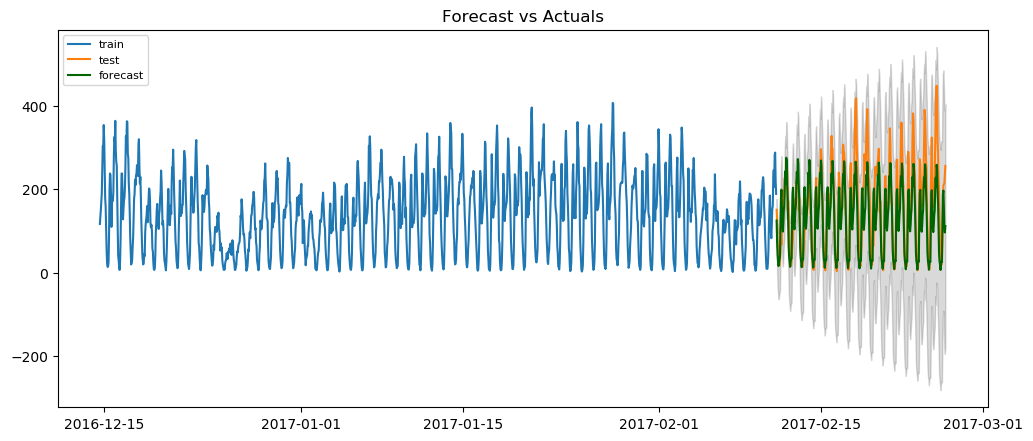

In [16]:
# Forecast
model.fit(c2g_travels_train)
n_periods = len(c2g_travels_test)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

# make series for plotting purpose
fc_series = pd.Series(fc, index=c2g_travels_test.index)
lower_series = pd.Series(confint[:, 0], index=c2g_travels_test.index)
upper_series = pd.Series(confint[:, 1], index=c2g_travels_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(c2g_travels_train, label='train')
plt.plot(c2g_travels_test, label='test')
plt.plot(fc_series, color='darkgreen', label='forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.title('Forecast vs Actuals')
plt.show()

In [17]:
forecast_accuracy(c2g_travels_test.values, fc_series.values)

{'corr': 0.8463449059056292,
 'mae': 47.13405318821226,
 'mape': 0.5064724380025499,
 'me': 31.49780707794834,
 'minmax': 0.29701343012530834,
 'mpe': 0.34466563235473285,
 'mse': 4002.185091725036}

In [ ]:
c2g_sarima_auto_feed = test_auto_feed(model, c2g_travels_train, c2g_travels_test, path='JISA/sarima/')

In [ ]:
c2g_sarima_future = test_future_period(model, c2g_travels_train, c2g_travels_test, path='JISA/sarima/')